"""
Complete process of IBD subtype diagnostic model (version 1)
Functions: data preprocessing → 14 types of model training → hyperparameter optimization → multidimensional evaluation → report generation
Environment requirements: Python 3.8+, Google Colab
"""

# =============== Environment Configuration ===============

In [ ]:
!python -m venv ibdsub_env

Error: Command '['/content/ibdsub_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [ ]:
!source ibdsub_env/bin/activate

/bin/bash: line 1: ibdsub_env/bin/activate: No such file or directory


In [ ]:
!pip install -q --force-reinstall \
    numpy==1.26.4 \
    pandas==2.2.2 \
    scikit-learn==1.3.2 \
    xgboost==1.7.5 \
    lightgbm==3.3.5 \
    catboost==1.2.6 \
    shap==0.44.0 \
    scipy==1.11.4

In [ ]:
!pip install dask[dataframe]

In [ ]:
import numpy as np
import pandas as pd
from pandas import json_normalize
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import joblib
from scipy.stats import sem, t
from sklearn import naive_bayes, metrics, model_selection, preprocessing, ensemble, svm, neural_network, neighbors, linear_model, discriminant_analysis
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import (roc_auc_score, precision_score, accuracy_score,
                            recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap

# =============== Parameter Configuration ===============

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 10
N_ITER = 10 # Total parameter combination number control
USE_GPU = False  # Force disable GPU to ensure compatibility

In [ ]:
# Configure matplotlib to display
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Sans serif fonts improve readability
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.titlesize': 10,         # Remove redundant headings
    'xtick.labelsize': 10,        # Scale Alignment Body Font Size
    'figure.dpi': 300,
    'savefig.bbox': 'tight'
})

=============== Data preparation ===============

In [ ]:
# Step 2: Upload data files
print("\nStep 2: Uploading data files...")

uploaded = files.upload()


Step 2: Uploading data files...


Saving CD_vs_UC_species_relative_abundance.xlsx to CD_vs_UC_species_relative_abundance (1).xlsx
Saving distinct_species.xlsx to distinct_species (1).xlsx
Saving shared_species.xlsx to shared_species (1).xlsx


In [ ]:
def load_data():
    # Data loading (example path, need to replace with real path)
    main_df = pd.read_excel('CD_vs_UC_species_relative_abundance.xlsx')
    # shared_species_df = pd.read_excel('shared_species.xlsx')

    # Data Cleaning
    labels = main_df.iloc[0, 1:].replace({'CD':1, 'UC':0}).astype(int)

    # feature engineering
    # Construct a characterization matrix (rows: species, columns: samples)
    features = main_df.iloc[1:, 1:].copy()
    features.index = main_df.iloc[1:, 0].str.split('s__').str[-1]  # Simplification of species names
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Weighting of shared species characteristics (example: 1x weight)
    # shared_species = shared_species_df.iloc[1:,0].str.split('s__').str[-1].tolist()
    # features.loc[features.index.intersection(shared_species)] *= 1.0

    return features.T, labels  # Transpose to sample x feature format

In [ ]:
# Data loading
print("Data loading...")
X, y = load_data()
print(f"data shape：{X.shape}，Category distribution：\n{y.value_counts()}")

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

加载数据...


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


数据形状：(811, 216)，类别分布：
0
1    424
0    387
Name: count, dtype: int64


=============== Model Configuration ===============

In [ ]:
def get_models_config():
    ratio = (y == 0).sum() / (y == 1).sum()  # Category Balance Ratio

    return {
        # integrated tree model
        'XGBoost': {
            'model': XGBClassifier(
                n_jobs=-1,
                scale_pos_weight=ratio,
                eval_metric='logloss',
                #use_label_encoder=False,
                tree_method='hist'  # Using the CPU Histogram Method
            ),
            'params': {
                'n_estimators': [200, 300, 400],
                'max_depth': [8, 9],
                'learning_rate': [0.07, 0.08]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(
                n_jobs=-1,
                scale_pos_weight=ratio,
                device='cpu'
            ),
            'params': {
                'num_leaves': [400, 500, 600],
                'max_depth': [9, 10, 11],
                'learning_rate': [0.1, 0.2, 0.3],
                'min_child_samples': [15, 20, 25]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(
                verbose=0,
                thread_count=-1,
                auto_class_weights='Balanced'
            ),
            'params': {
                'iterations': [200, 400],
                'depth': [5, 8, 9],
                'learning_rate': [0.06, 0.08]
            }
        },
        'RandomForest': {
            'model': ensemble.RandomForestClassifier(
                n_jobs=-1,
                class_weight='balanced'
            ),
            'params': {
                'n_estimators': [200, 400],
                'max_depth': [10, 11, 12],
                'min_samples_split': [7, 8]
            }
        },

        # linear model
        'Logistic': {
            'model': linear_model.LogisticRegression(
                class_weight='balanced',
                solver='saga',
                n_jobs=-1,
                max_iter=9000,
                tol=1e-9
            ),
            'params': {
                'C': np.logspace(-3, -1, 1, 1.5, 2),
                'penalty': ['l1', 'l2']
            }
        },

        # Other models
        'SVM': {
            'model': svm.SVC(
                probability=True,
                class_weight='balanced',
                kernel='rbf'
            ),
            'params': {
                'C': [4, 5, 6, 7, 8],
                'gamma': ['scale', 'auto']
            }
        },
        'KNN': {
            'model': neighbors.KNeighborsClassifier(
                n_jobs=1
            ),
            'params': {
                'n_neighbors': [5, 6, 7, 8, 9],
                'weights': ['uniform', 'distance']
            }
        },
        'HistGBM': {
            'model': ensemble.HistGradientBoostingClassifier(),
            'params': {
                'max_iter': [200, 400],
                'learning_rate': [0.15, 1.16, 0.2],
                'max_depth': [9, 10]
            }
        },
        # Gradient lifting variant
        'AdaBoost': {
            'model': ensemble.AdaBoostClassifier(),
            'params': {
                'n_estimators': [1000, 1200],
                'learning_rate': [0.7, 0.8, 0.9],
                'algorithm': ['SAMME', 'SAMME.R']
            }
        },

        # neural network
        'MLP': {
            'model': neural_network.MLPClassifier(
                early_stopping=True,
                batch_size=32,
                max_iter=500
            ),
            'params': {
                'hidden_layer_sizes': [(64,), (64,32), (64,64)],
                'alpha': [0.001, 0.01],
                'learning_rate_init': [0.0001, 0.01, 0.02]
            }
        },

        # probabilistic model
        'GaussianNB': {
            'model': naive_bayes.GaussianNB(),
            'params': {
                'var_smoothing': [1e-5, 1e-4, 1e-3]
            }
        },

        # incremental learning
        'SGD': {
            'model': linear_model.SGDClassifier(
                loss='log_loss',  # Enabling probabilistic forecasting
                class_weight='balanced',
                early_stopping=True
            ),
            'params': {
                'alpha': [1e-2, 1e-1, 1],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'l1_ratio': [0.4, 0.5, 0.6]
            }
        },

        # discriminant analysis
        'LDA': {
            'model': discriminant_analysis.LinearDiscriminantAnalysis(solver='lsqr'),
            'params': {
                'shrinkage': ['auto', 0.3, 0.55], # Legal parameters adapted to the new solver
                'tol': [1e-5, 1e-4, 1e-3, 1e-2]
            }
        },

        # Extreme Random Trees
        'ExtraTrees': {
            'model': ensemble.ExtraTreesClassifier(
                class_weight='balanced',
                n_jobs=-1
            ),
            'params': {
                'n_estimators': [100, 120, 150],
                'max_depth': [14, 15, 16],
                'min_samples_split': [2, 3, 5]
            }
        }
    }

=============== model training ===============

In [ ]:
def train_models():
    results = {}
    plt.figure(figsize=(12, 8))
    models_config = get_models_config()

    def bootstrap_auc(y_true, y_proba, n_bootstrap=1000):
        auc_values = []
        for _ in range(n_bootstrap):
            indices = resample(np.arange(len(y_true)))
            auc = metrics.roc_auc_score(y_true.iloc[indices], y_proba[indices])
            auc_values.append(auc)
        return np.percentile(auc_values, [2.5, 97.5])

    for name, config in models_config.items():
        try:
            print(f"\n=== Training {name} [{time.strftime('%H:%M:%S')}] ===")
            start_time = time.time()

            # Hyperparametric search
            search = model_selection.RandomizedSearchCV(
                estimator=config['model'],
                param_distributions=config['params'],
                n_iter=N_ITER,
                cv=model_selection.StratifiedKFold(CV_FOLDS),
                scoring='roc_auc',
                n_jobs=-1,
                error_score='raise'
            )
            search.fit(X_train, y_train)

            # Projected results
            y_pred = search.predict(X_test)
            y_prob = search.predict_proba(X_test)[:, 1]

            # Calculation of indicators
            auc_ci = bootstrap_auc(y_test, y_prob)
            report = metrics.classification_report(y_test, y_pred, output_dict=True)

            # Save results
            results[name] = {
                'model': search.best_estimator_,
                'best_params': search.best_params_,
                'auc': metrics.roc_auc_score(y_test, y_prob),
                'auc_ci': auc_ci,
                'precision': metrics.precision_score(y_test, y_pred),
                'recall': metrics.recall_score(y_test, y_pred),
                'accuracy': report['accuracy'],
                'f1': report['1']['f1-score'],
                'time': time.time() - start_time
            }

            # Plotting the ROC curve
            fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, lw=2.5, marker='o', ms=5,
              label=f"{name} (AUC={results[name]['auc']:.3f}, 95% CI: {results[name]['auc_ci'][0]:.3f}-{results[name]['auc_ci'][1]:.3f})")

        except Exception as e:
            print(f"train {name} fail (e.g. experiments): {str(e)}")
            continue

    # Drawing settings optimization
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel('False Positive Rate', fontsize=12, labelpad=8)
    plt.ylabel('True Positive Rate', fontsize=12, labelpad=8)
    plt.title('ROC Curve (CD_vs_UC)', fontsize=14, pad=12)
    plt.legend(loc='lower right', frameon=True,
              fontsize=9, borderpad=0.8)

    # Setting the saving parameters
    plt.savefig('/content/drive/MyDrive/code/IBD/2stage/stage2/roc_comparison.png',
              dpi=300,
              bbox_inches='tight',
              pad_inches=0.2)

    return results


=============== Executive training ===============


=== Training XGBoost [09:35:20] ===

=== Training LightGBM [09:35:55] ===

=== Training CatBoost [09:36:03] ===


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



=== Training RandomForest [09:49:12] ===


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



=== Training Logistic [09:49:31] ===


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
The max_iter was reached which means the coef_ did not converge



=== Training SVM [09:50:26] ===

=== Training KNN [09:50:32] ===

=== Training HistGBM [09:50:34] ===

=== Training AdaBoost [09:51:06] ===

=== Training MLP [09:53:07] ===

=== Training GaussianNB [09:53:14] ===


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.



=== Training SGD [09:53:16] ===

=== Training LDA [09:53:18] ===

=== Training ExtraTrees [09:53:20] ===


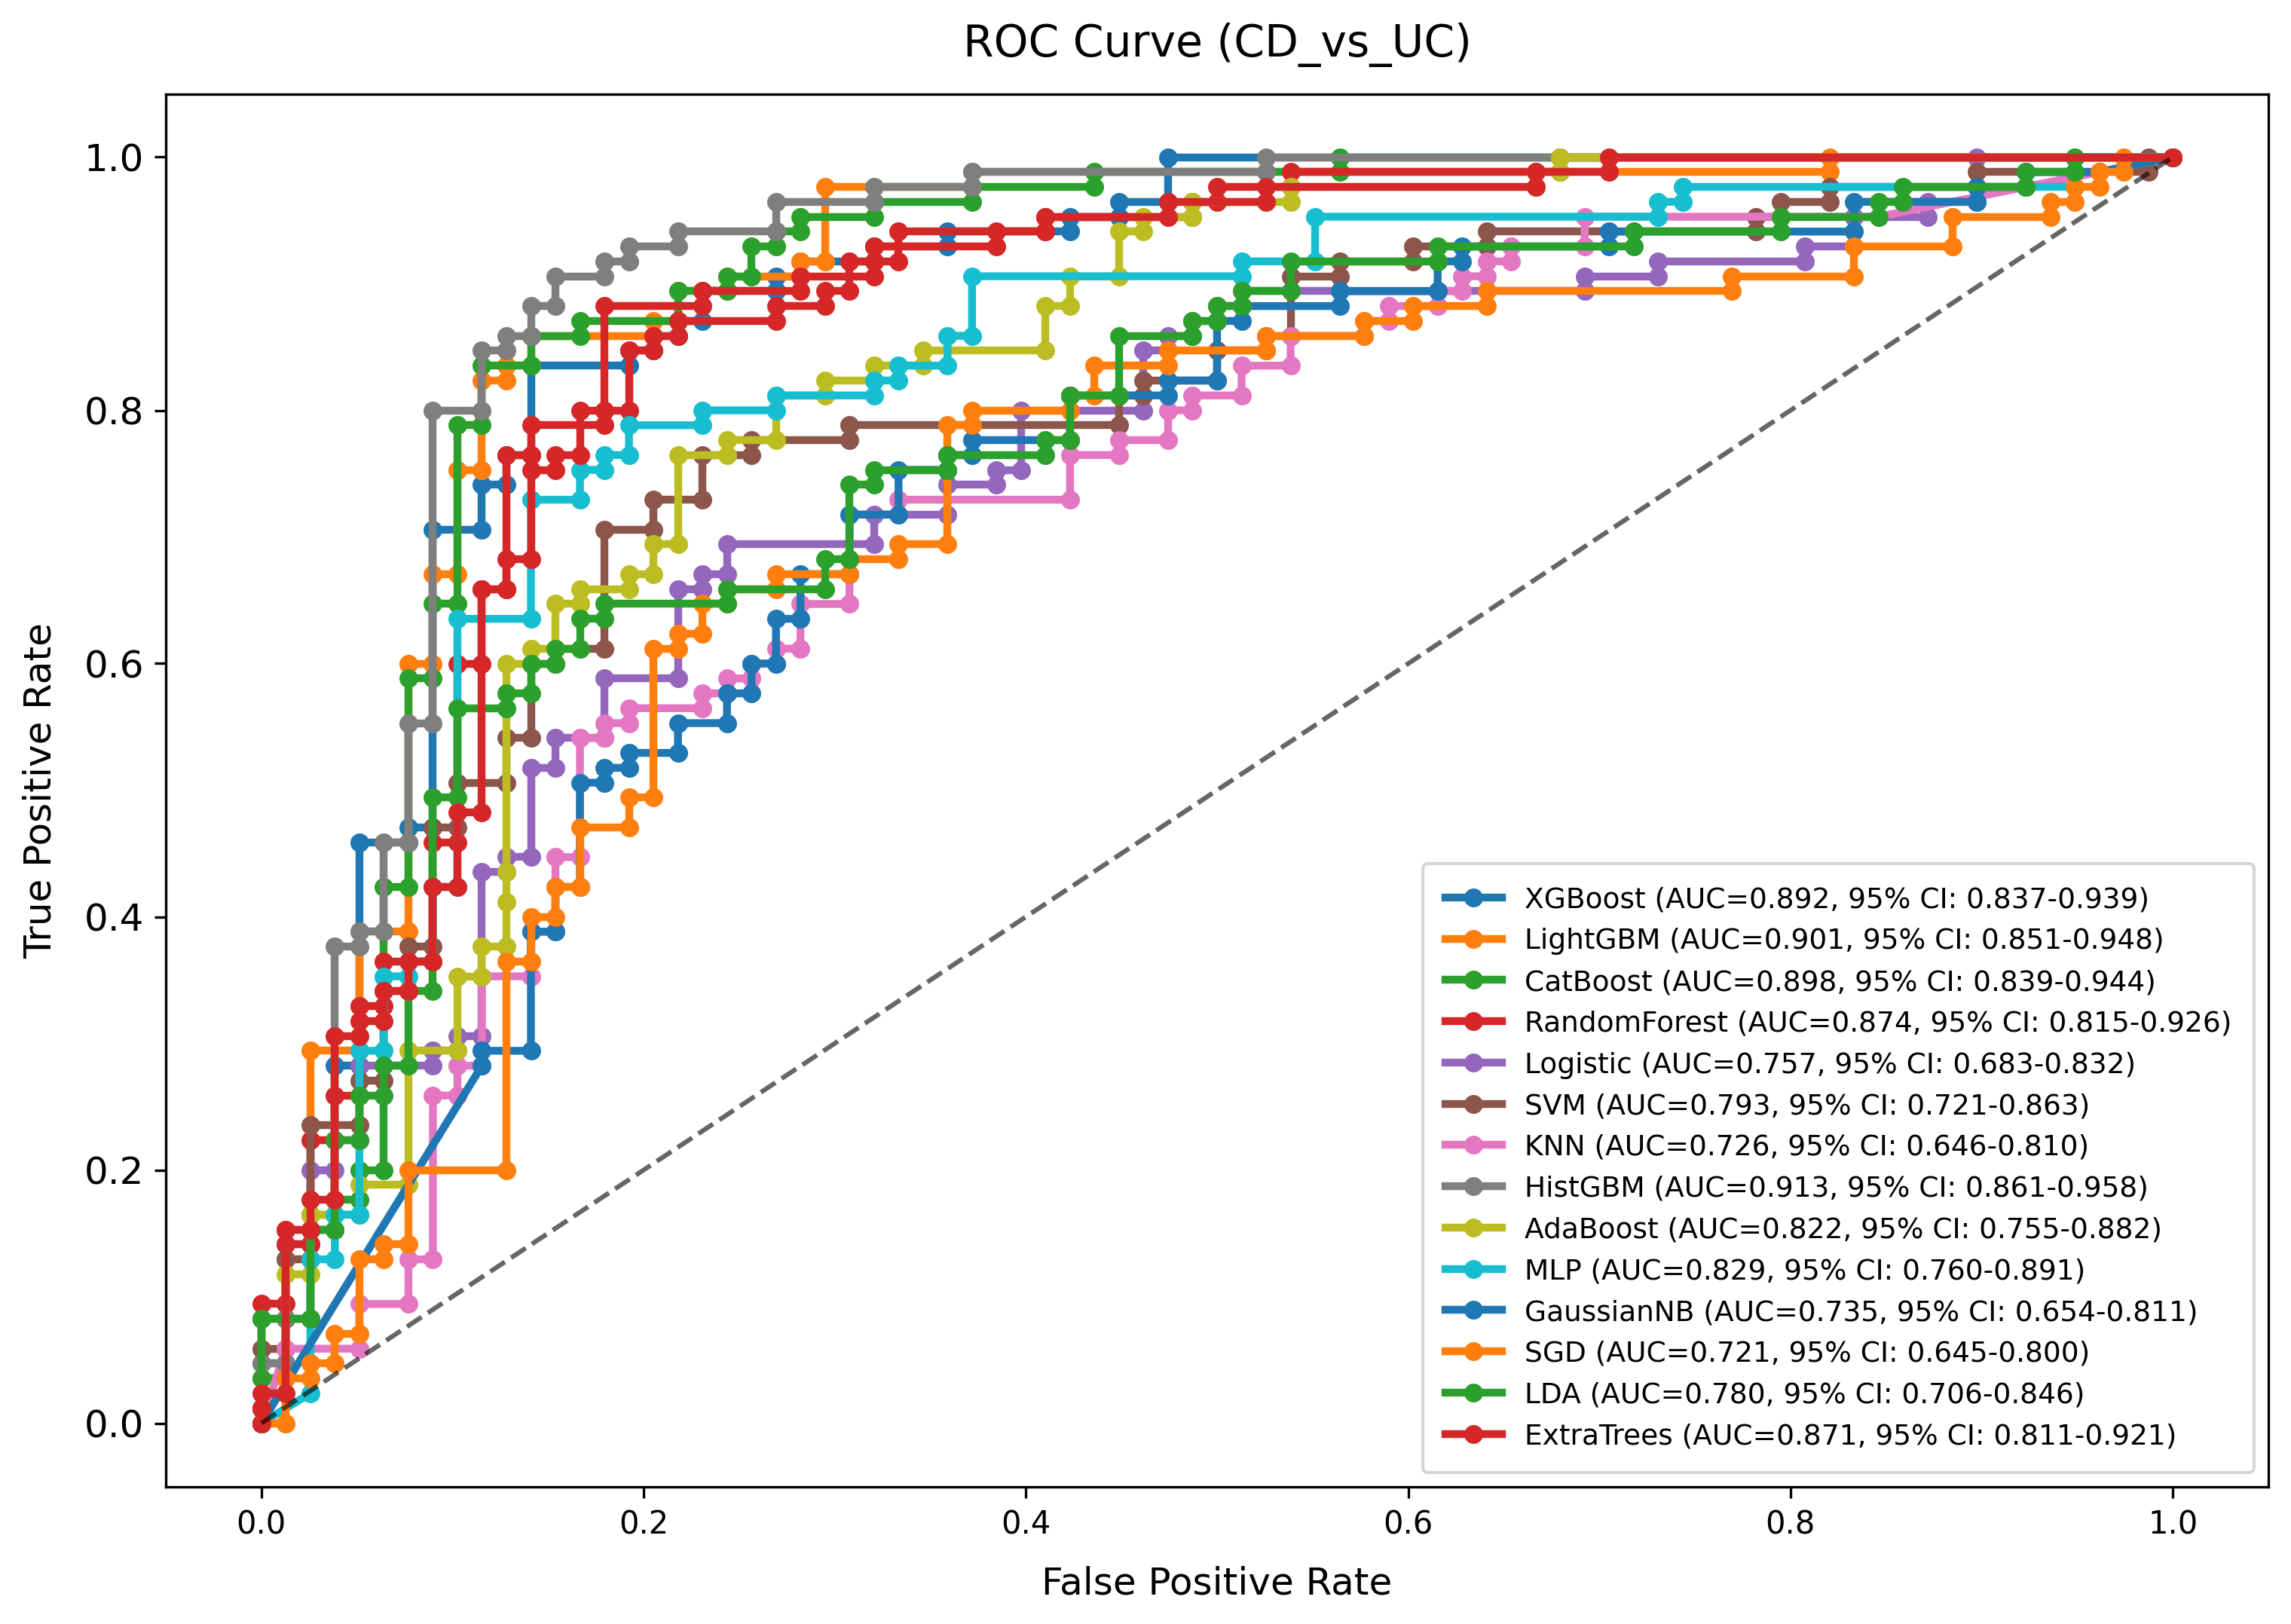

In [ ]:
results = train_models()

In [ ]:
# Updated parameter table generation logic
params_list = []
for model_name, res in results.items():
    try:
        # Handling nested dictionary parameter structures
        flat_params = pd.json_normalize(res['best_params'], sep='__').to_dict(orient='records')[0]
        params_list.append({
            'Model': model_name,
            'Best_Parameters': '\n'.join([f"{k}: {v}" for k, v in flat_params.items()])
        })
    except:
        params_list.append({
            'Model': model_name,
            'Best_Parameters': str(res['best_params'])
        })

params_df = pd.DataFrame(params_list)
params_df.sort_values('Model', inplace=True)

# Optimized display format
from IPython.display import display, HTML
display(HTML(params_df.style
            .set_properties(**{'white-space': 'pre-wrap'})
            .set_table_styles([{
                'selector': 'th',
                'props': [('text-align', 'left'), ('max-width', '300px')]
            }])
            .to_html()))

In [ ]:
# Generate a performance comparison table
final_metrics = pd.DataFrame(
    [(name,
      f"{res['auc']:.3f} ({res['auc_ci'][0]:.3f}-{res['auc_ci'][1]:.3f})",
      res['accuracy'],
      res['precision'],  # Use of independently stored values
      res['recall'],
      res['f1'],
      res['time'])
     for name, res in results.items()],
    columns=['Model', 'AUC (95% CI)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Time']
).sort_values('AUC (95% CI)', ascending=False)

In [ ]:
final_metrics

Model         AUC (95% CI)  Accuracy  Precision    Recall  \
7        HistGBM  0.913 (0.861-0.958)  0.852761   0.906667  0.800000   
1       LightGBM  0.901 (0.851-0.948)  0.846626   0.875000  0.823529   
2       CatBoost  0.898 (0.839-0.944)  0.834356   0.881579  0.788235   
0        XGBoost  0.892 (0.837-0.939)  0.815951   0.866667  0.764706   
3   RandomForest  0.874 (0.815-0.926)  0.815951   0.857143  0.776471   
13    ExtraTrees  0.871 (0.811-0.921)  0.785276   0.847222  0.717647   
9            MLP  0.829 (0.760-0.891)  0.785276   0.847222  0.717647   
8       AdaBoost  0.822 (0.755-0.882)  0.766871   0.790123  0.752941   
5            SVM  0.793 (0.721-0.863)  0.754601   0.808219  0.694118   
12           LDA  0.780 (0.706-0.846)  0.717791   0.809524  0.600000   
4       Logistic  0.757 (0.683-0.832)  0.687117   0.774194  0.564706   
10    GaussianNB  0.735 (0.654-0.811)  0.619632   0.744681  0.411765   
6            KNN  0.726 (0.646-0.810)  0.668712   0.771930  0.517647   
11           SGD  0.721 (0.645-0.800)  0.705521   0.753425  0.647059   

    F1-Score        Time  
7   0.850000   32.119509  
1   0.848485    7.350840  
2   0.832298  789.786773  
0   0.812500   35.186824  
3   0.814815   18.818530  
13  0.777070    7.354233  
9   0.777070    6.956190  
8   0.771084  121.550924  
5   0.746835    5.358761  
12  0.689189    2.078172  
4   0.653061   54.990690  
10  0.530303    1.729504  
6   0.619718    1.880356  
11  0.696203    1.976456

In [ ]:
# Extracting the best model
best_model_name = final_metrics.iloc[0]['Model']
best_model = results[best_model_name]['model']

In [ ]:
# Results Showcase
print("\n=== Model Performance Comparison ===")
print(final_metrics.round(3).to_markdown())
print(f"\nbest model：{best_model_name}")


=== 模型性能对比 ===
|    | Model        | AUC (95% CI)        |   Accuracy |   Precision |   Recall |   F1-Score |    Time |
|---:|:-------------|:--------------------|-----------:|------------:|---------:|-----------:|--------:|
|  7 | HistGBM      | 0.913 (0.861-0.958) |      0.853 |       0.907 |    0.8   |      0.85  |  32.12  |
|  1 | LightGBM     | 0.901 (0.851-0.948) |      0.847 |       0.875 |    0.824 |      0.848 |   7.351 |
|  2 | CatBoost     | 0.898 (0.839-0.944) |      0.834 |       0.882 |    0.788 |      0.832 | 789.787 |
|  0 | XGBoost      | 0.892 (0.837-0.939) |      0.816 |       0.867 |    0.765 |      0.812 |  35.187 |
|  3 | RandomForest | 0.874 (0.815-0.926) |      0.816 |       0.857 |    0.776 |      0.815 |  18.819 |
| 13 | ExtraTrees   | 0.871 (0.811-0.921) |      0.785 |       0.847 |    0.718 |      0.777 |   7.354 |
|  9 | MLP          | 0.829 (0.760-0.891) |      0.785 |       0.847 |    0.718 |      0.777 |   6.956 |
|  8 | AdaBoost     | 0.822 (0.755-0.88

In [ ]:
joblib.dump({
    'model': best_model,
    'feature_names': X_train.columns.tolist(),
    'feature_stats': X_train.agg(['min', 'max']).to_dict()
}, '/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_best_model_with_meta.pkl')

['/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_best_model_with_meta.pkl']

In [ ]:
# Preservation of optimal models
joblib.dump(best_model, '/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_best_model.pkl')

['/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_best_model.pkl']

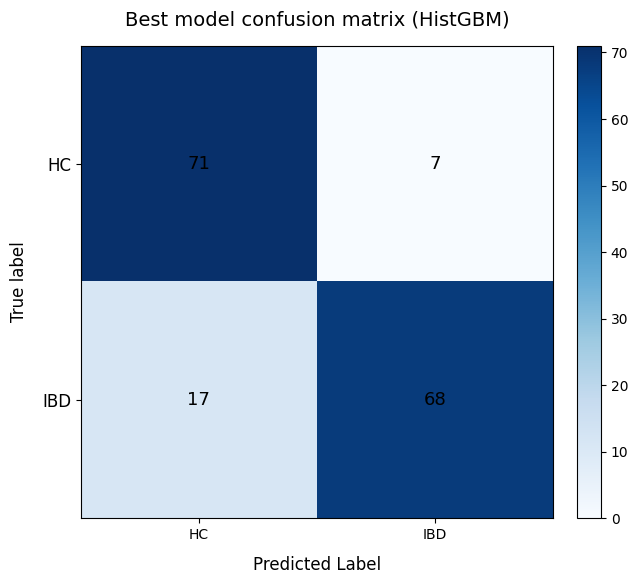

In [ ]:
# === confusion matrix (math.) ===
# Creating a Submap System
fig, ax = plt.subplots(figsize=(7,6), dpi=100)

# Calculate the best model predictions
best_model = results[best_model_name]['model']
y_pred_all = best_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_all)

# Normalized Confusion Matrix Presentation (to maintain consistency with SHAP chart aesthetics)
conf_disp = ConfusionMatrixDisplay(
    conf_mat,
    display_labels=['HC', 'IBD']
)
conf_disp.plot(
    cmap='Blues',
    colorbar=False,
    values_format='d',
    ax=ax,
    text_kw={
        'fontsize': 13,
        'color': 'black'
    }
)


ax.set_xlabel('Predicted Label',
             fontsize=12,
             fontfamily='DejaVu Sans',
             labelpad=10)
ax.set_ylabel('True label',
             fontsize=12,
             fontfamily='DejaVu Sans',
             labelpad=10)
ax.set_title(f'Best model confusion matrix ({best_model_name})',
           fontsize=14,
           pad=15,
           fontfamily='DejaVu Sans')


norm = plt.Normalize(vmin=0, vmax=conf_mat.max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                  ax=ax,
                  fraction=0.046,
                  pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/code/IBD/2stage/stage2/best_model_confusion_matrix.png',
          bbox_inches='tight',
          dpi=300)
plt.show()


Performing SHAP analysis for model interpretability...

Generating custom-colored SHAP bar plot...

Generating SHAP beeswarm plot with consistent colors...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


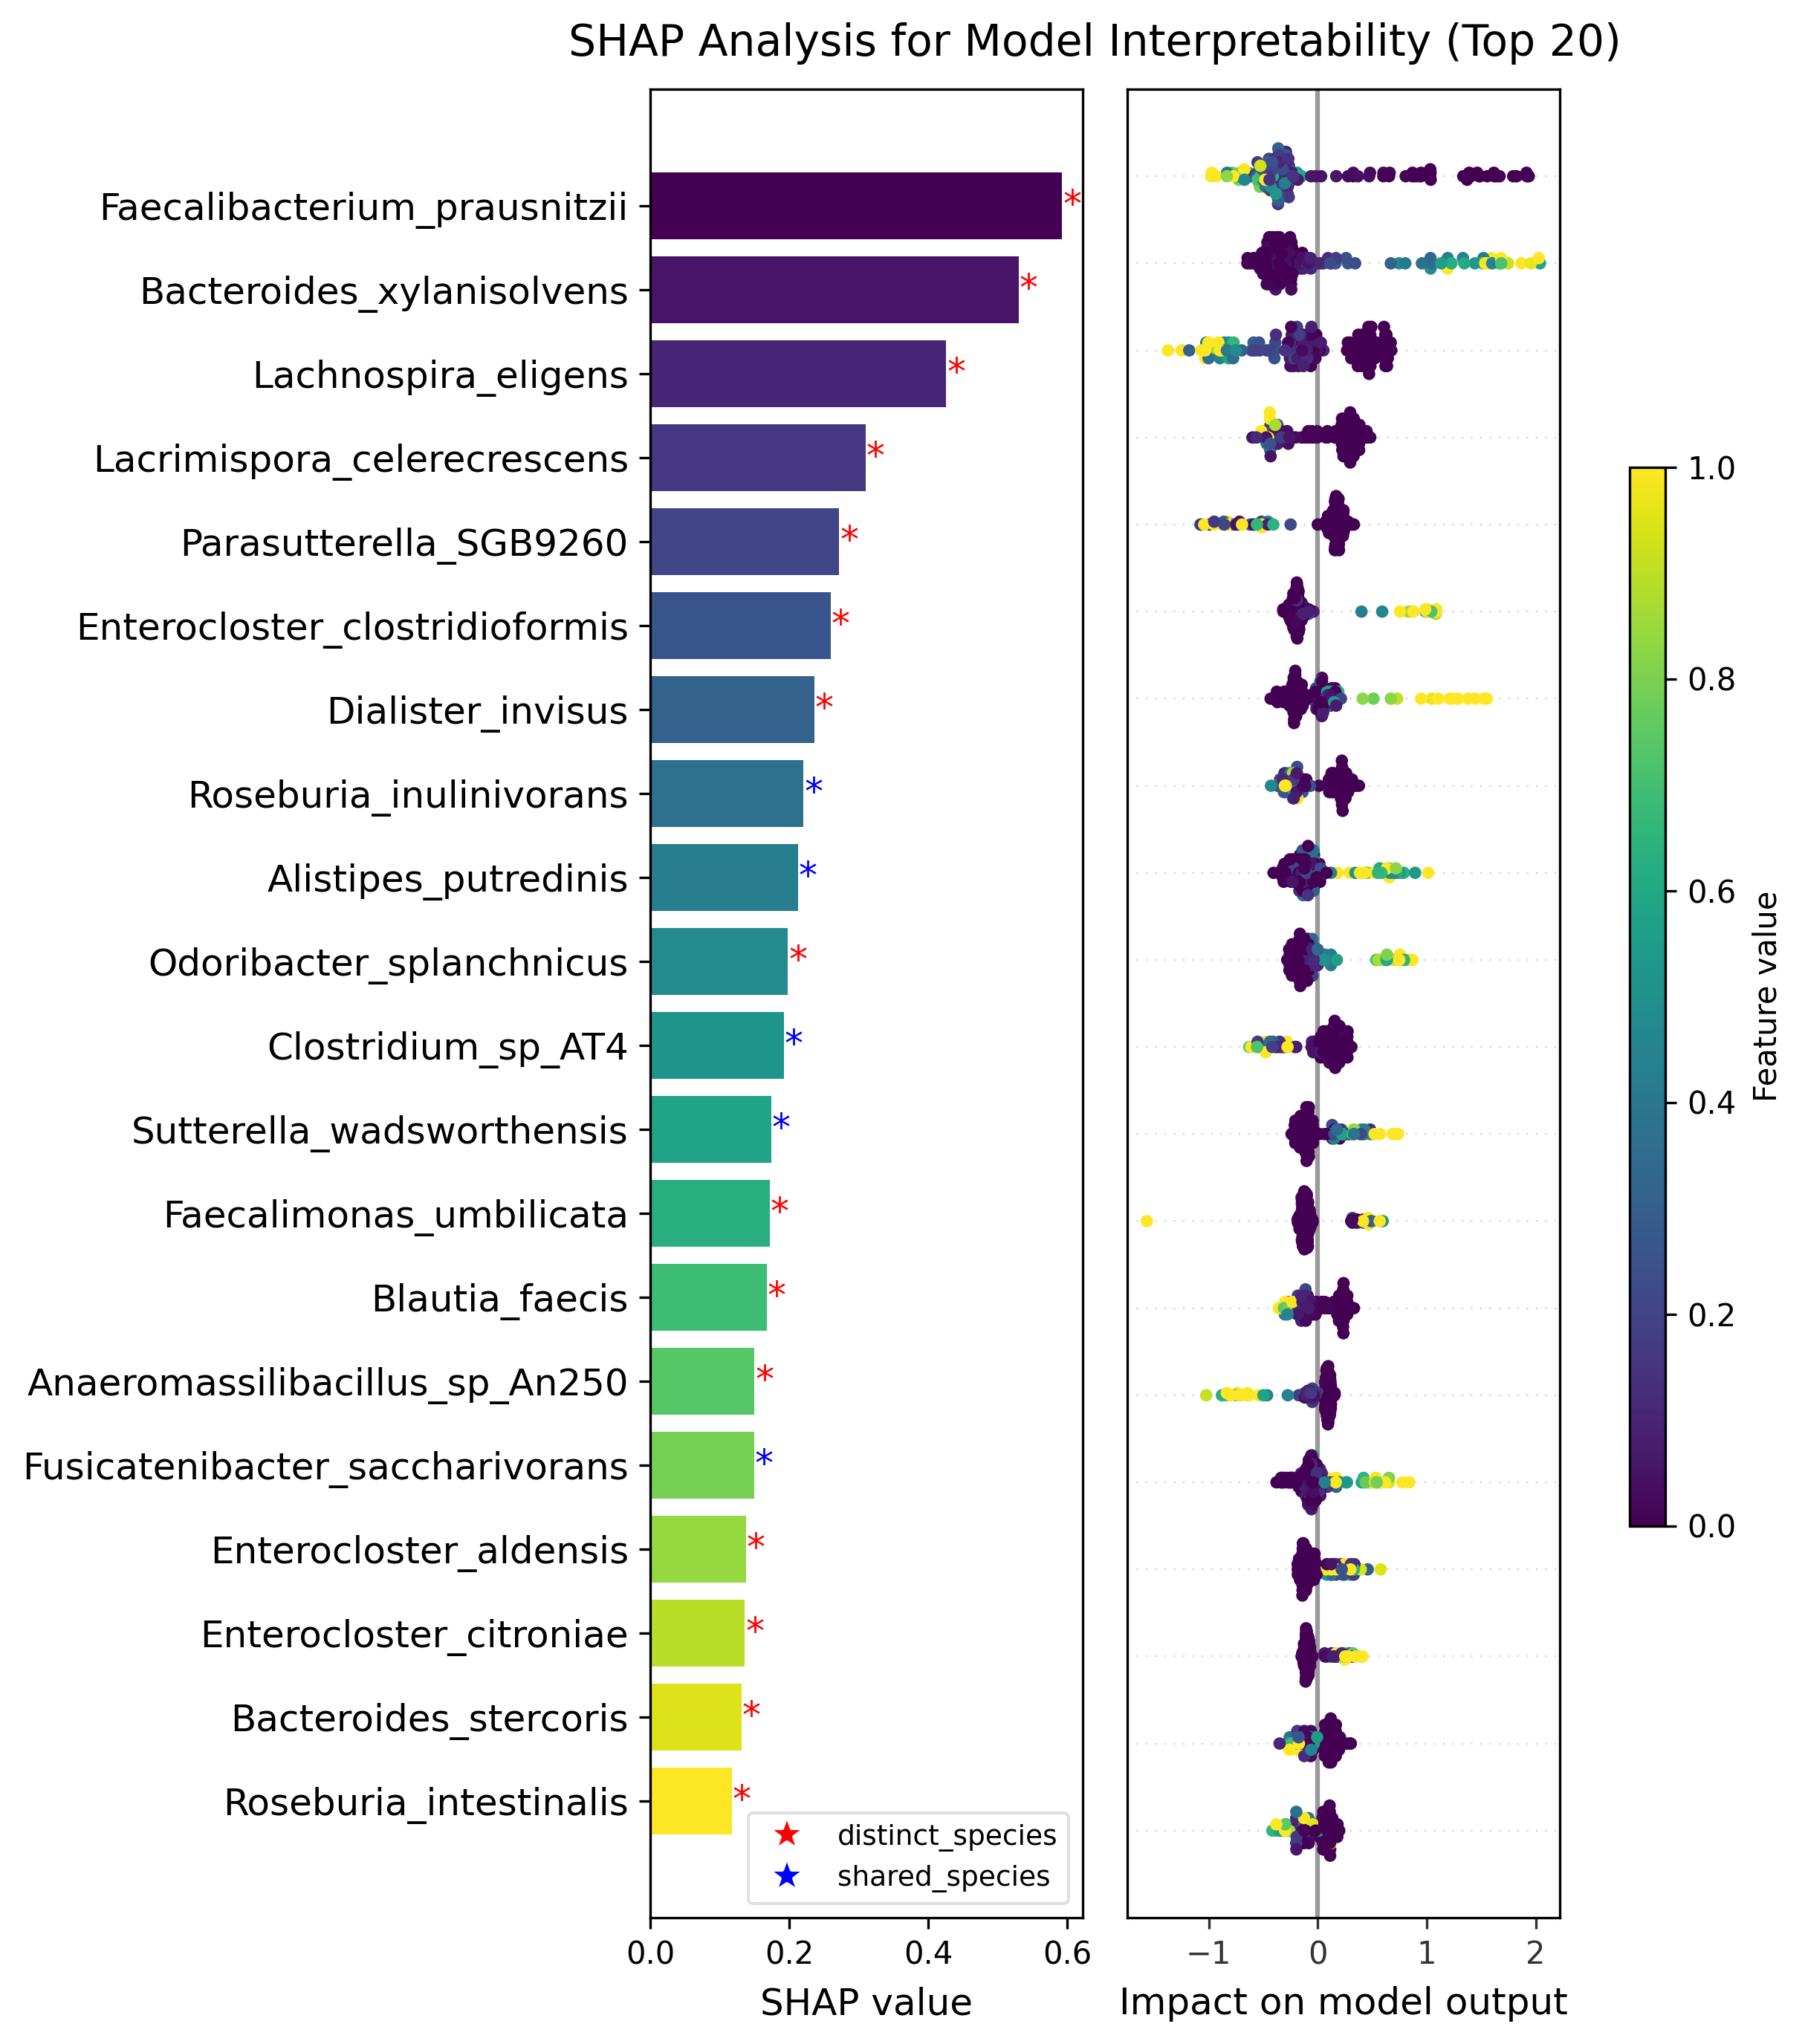

In [ ]:
# Reading a list of specific bacteria from a file
distinct_species_df = pd.read_excel('distinct_species.xlsx')
# Converting a list of specific bacteria to a list
distinct_species_list = distinct_species_df.iloc[:, 0].tolist()
# Species name after extraction of s__
distinct_species_list = distinct_species_df.iloc[:, 0].apply(lambda x: x.split('s__')[-1]).tolist()

# Read the list of commensal bacteria from the file
shared_species_df = pd.read_excel('shared_species.xlsx')
# Converting a list of commensal bacteria to a list
shared_species_list = shared_species_df.iloc[:, 0].tolist()
# Species name after extraction of s__
shared_species_list = shared_species_df.iloc[:, 0].apply(lambda x: x.split('s__')[-1]).tolist()


# Set font for all plots
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Global font size for readability
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Axis label font size
plt.rcParams['xtick.labelsize'] = 10  # X-tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y-tick label size

# SHAP Analysis for model interpretability
print("\nPerforming SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(best_model)

# Generate SHAP values using explainer on X_test
shap_values_explanation = explainer(X_test)
shap_values = shap_values_explanation

# Create figure and set size to align both plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)  # Slightly increase space between the two plots

# 1. Custom-colored SHAP bar plot
print("\nGenerating custom-colored SHAP bar plot...")
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns

# Store feature importance in DataFrame and sort by importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

# Custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))

# Plot custom bar plot
axes[0].barh(importance_df['feature'], importance_df['importance'], color=colors)

legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=12, label='distinct_species'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=12, label='shared_species')
]

axes[0].legend(handles=legend_elements,
              loc='lower right',
              frameon=True,
              framealpha=0.9,
              edgecolor='#DDDDDD',
              title='',
              title_fontsize=10,
              fontsize=9)

axes[0].invert_yaxis()

# Add strain labeling
for i, feature in enumerate(importance_df['feature']):
    if feature in distinct_species_list:
      # Add a red star for distinct species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='red', fontsize=12, va='center')
    elif feature in shared_species_list:
      # Add a blue star for shared species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='blue', fontsize=12, va='center')

# Hide x-axis label and title by setting them as empty strings
axes[0].set_xlabel("SHAP value", fontsize=12)  # Hide x-axis label for the bar plot
axes[0].set_title("")   # Hide title for the bar plot
axes[0].tick_params(axis='y', labelsize=12)  # Increase font size for feature names

# Set consistent x-axis tick parameters for the bar plot
axes[0].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# 2. SHAP beeswarm plot with consistent colors
print("\nGenerating SHAP beeswarm plot with consistent colors...")
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20, show=False, color_bar=False, cmap="viridis")
axes[1].tick_params(labelleft=False)
axes[1].tick_params(left=False)
axes[1].set_title("")   # Hide title for beeswarm plot
axes[1].set_xlabel("Impact on model output", fontsize=12)  # Hide x-axis label for beeswarm plot
axes[1].spines[['left', 'right', 'top']].set_visible(True)

# Set consistent x-axis tick parameters for the beeswarm plot
axes[1].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# Add a color bar next to the beeswarm plot with adjusted size
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted color bar position and size
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label="Feature value", orientation='vertical')

# Adjust layout and save image with high resolution
# Add before plt.tight_layout()
fig.suptitle('SHAP Analysis for Model Interpretability (Top 20)',
            x=0.62,  # Precise horizontal positioning
            y=0.96,  # Precise vertical positioning
            fontsize=14,
            fontweight='normal')
# Adjusting the layout to reserve header space
plt.tight_layout(rect=[0, 0, 0.9, 0.98])  # Reserve top 5% space
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage2/SHAP_CD_vs_UC.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

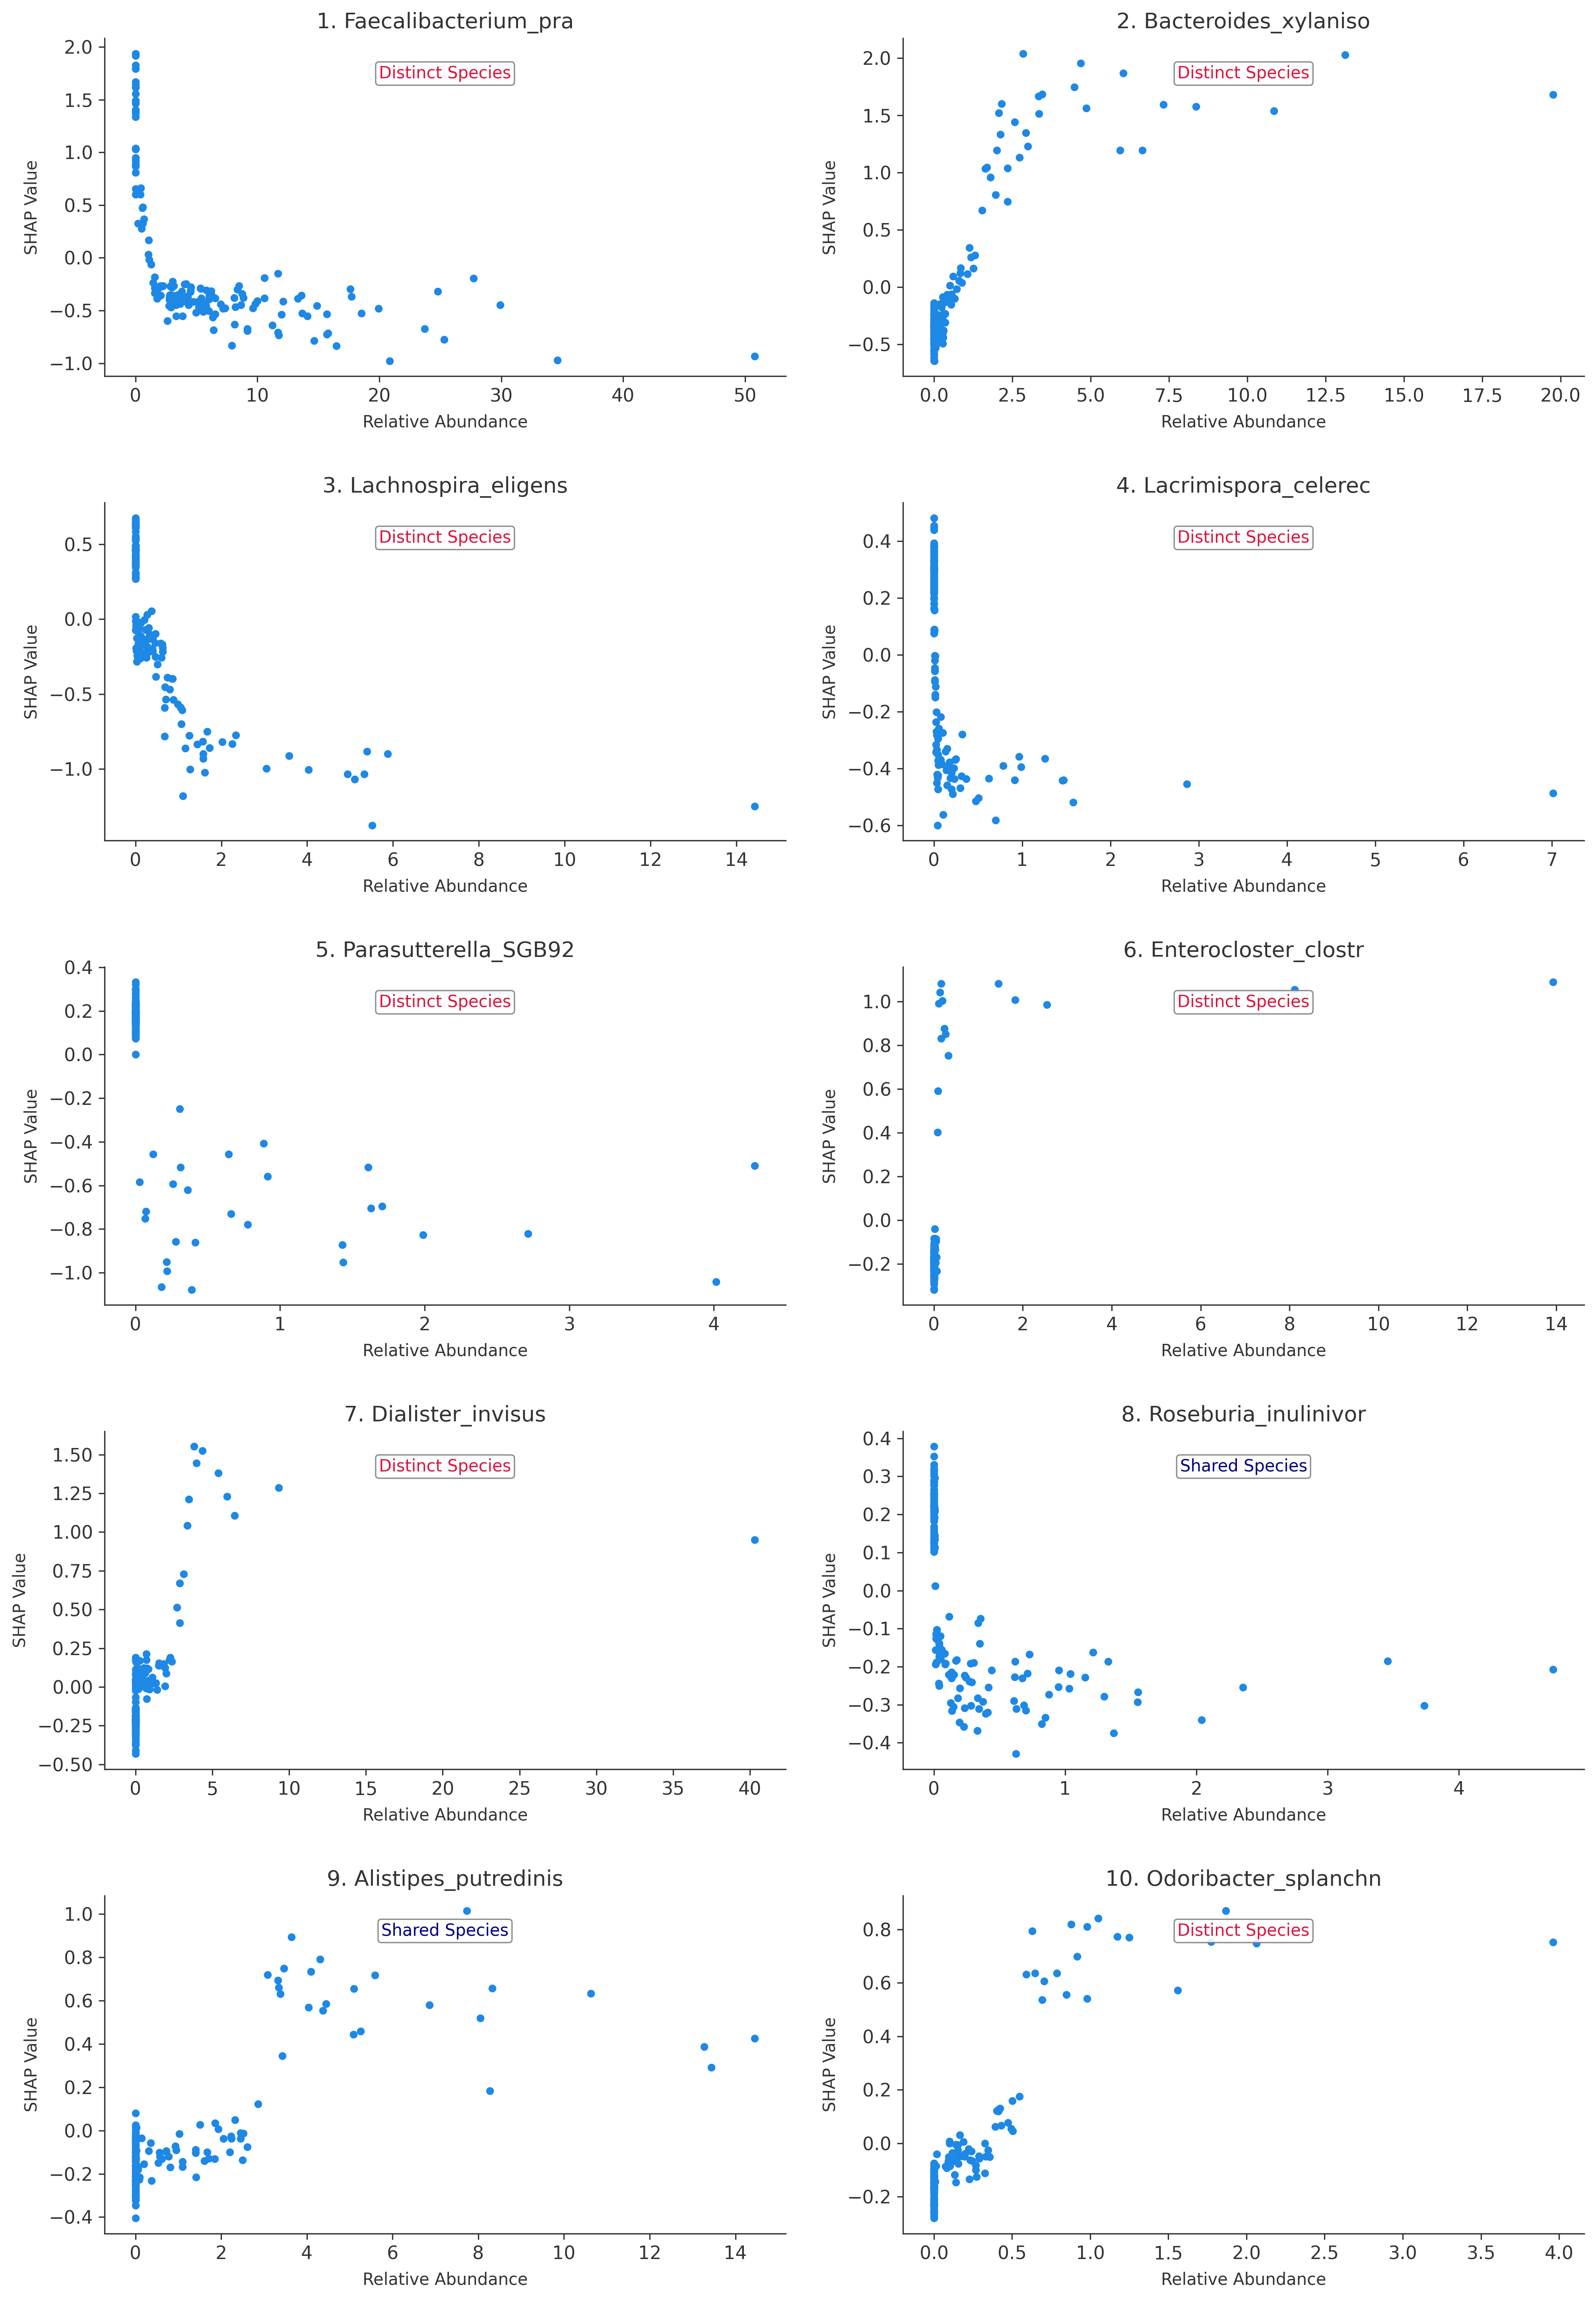

In [ ]:
# Generate a detailed dependency graph for the top 10 features
top10_features = importance_df['feature'].head(10).tolist()


plt.figure(figsize=(14, 20))
plt.rcParams.update({'font.size': 11, 'axes.labelpad': 5})

for i, feature in enumerate(top10_features, 1):
    ax = plt.subplot(5, 2, i)


    cmap = plt.cm.Reds if feature in distinct_species_list else plt.cm.Blues

    # Dependency mapping
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_test,
        interaction_index=None,
        ax=ax,
        title=f"{i}. {feature[:20]}".rstrip('_'),
        cmap=cmap,
        dot_size=22,
        show=False
    )


    ax.set_xlabel("Relative Abundance", fontsize=10)
    ax.set_ylabel("SHAP Value", fontsize=10)


    label_y_position = 0.92
    bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="grey", lw=0.8, alpha=0.9)

    if feature in distinct_species_list:
        ax.text(0.5, label_y_position, 'Distinct Species',
               color='crimson', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)
    elif feature in shared_species_list:
        ax.text(0.5, label_y_position, 'Shared Species',
               color='navy', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)


plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=2.0)
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage2/SHAP_dependence_top10_features.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# === A posteriori feature optimization system ===
# Inputs: full model, SHAP importance data frame, raw data
def post_hoc_feature_selection(model, importance_df, X_full, y_full, top_n=30, stability_threshold=0.8):
    """
    Dynamic selection system based on feature importance

    parameters:
    model : trained optimal model
    importance_df : data frame with 'feature' and 'importance' columns
    x : original feature matrix
    y : target variable
    top_n : number of features in the first sieve
    stability_threshold : stability threshold of features
    """

    assert isinstance(X_full, pd.DataFrame), "X_full must be DataFrame"
    assert X_full.shape[0] == len(y_full), f"Sample size mismatch X:{X_full.shape[0]} vs y:{len(y_full)}"

    # Stage 1: Initial screening
    primary_features = importance_df.head(top_n)['feature'].tolist()
    X_primary = X_full[primary_features]

    # Phase 2: Stability Validation
    stability_scores = bootstrap_feature_stability(model, X_primary, y_full)
    stable_features = [f for f, s in zip(primary_features, stability_scores)
                      if s >= stability_threshold]

    # Phase 3: Performance Verification
    X_stable = X_full[stable_features]
    final_features = validate_feature_performance(model, X_full, X_stable, y_full)

    return final_features

def bootstrap_feature_stability(model, X, y, n_samples=50):
    """Stability test after accelerated treatment"""
    feature_counts = pd.Series(0, index=X.columns)
    for _ in range(n_samples):
        X_res, y_res = resample(X, y, stratify=y)
        model_clone = clone(model).fit(X_res, y_res)

        explainer = shap.TreeExplainer(model_clone)
        shap_values = explainer.shap_values(X_res)
        if isinstance(shap_values, list):
            imp = np.abs(shap_values[1]).mean(0)  # Orthoclasses of the dichotomy
        else:
            imp = np.abs(shap_values).mean(0)

        top_features = pd.Series(imp, index=X.columns).nlargest(20).index
        feature_counts[top_features] +=1

    return feature_counts / n_samples

def validate_feature_performance(model, X_full, X_subset, y, cv=3):
    """Optimized performance validation"""
    assert X_full.shape[0] == X_subset.shape[0], "Sample size must be consistent"

    base_score = cross_val_score(model, X_full, y, cv=cv, n_jobs=-1).mean()
    subset_score = cross_val_score(model, X_subset, y, cv=cv, n_jobs=-1).mean()

    print(f"[Performance Comparison] Full Features: {base_score:.4f} | subset of features (math.): {subset_score:.4f}")
    return X_subset.columns.tolist() if subset_score >= base_score * 0.95 else X_full.columns.tolist()

# usage example  -------------------------------------------------
print(f"Raw feature count: {X_train.shape[1]}")
final_features = post_hoc_feature_selection(
    best_model,
    importance_df,
    X_train,
    y_train,
    top_n=30
)
print(f"Number of final screening features: {len(final_features)}")

原始特征数: 216
【性能对比】完整特征: 0.8534 | 特征子集: 0.8395
最终筛选特征数: 20


Degrees of freedom <= 0 for slice
invalid value encountered in scalar divide
Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from font(s) DejaVu Sans.



=== 性能对比报告 ===
+--------+---------------------+---------------------+
| 指标   | 原模型              | 精简模型            |
+========+=====================+=====================+
| AUC    | 0.914 (0.860-0.957) | 0.874 (0.000-1.000) |
+--------+---------------------+---------------------+
| 准确率 | 0.822               | 0.840               |
+--------+---------------------+---------------------+
| 精确率 | 0.889               | 0.855               |
+--------+---------------------+---------------------+
| 召回率 | 0.753               | 0.835               |
+--------+---------------------+---------------------+
| F1分数 | 0.815               | 0.845               |
+--------+---------------------+---------------------+


['/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_pruned_model.pkl']

Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from font(s) DejaVu Sans.


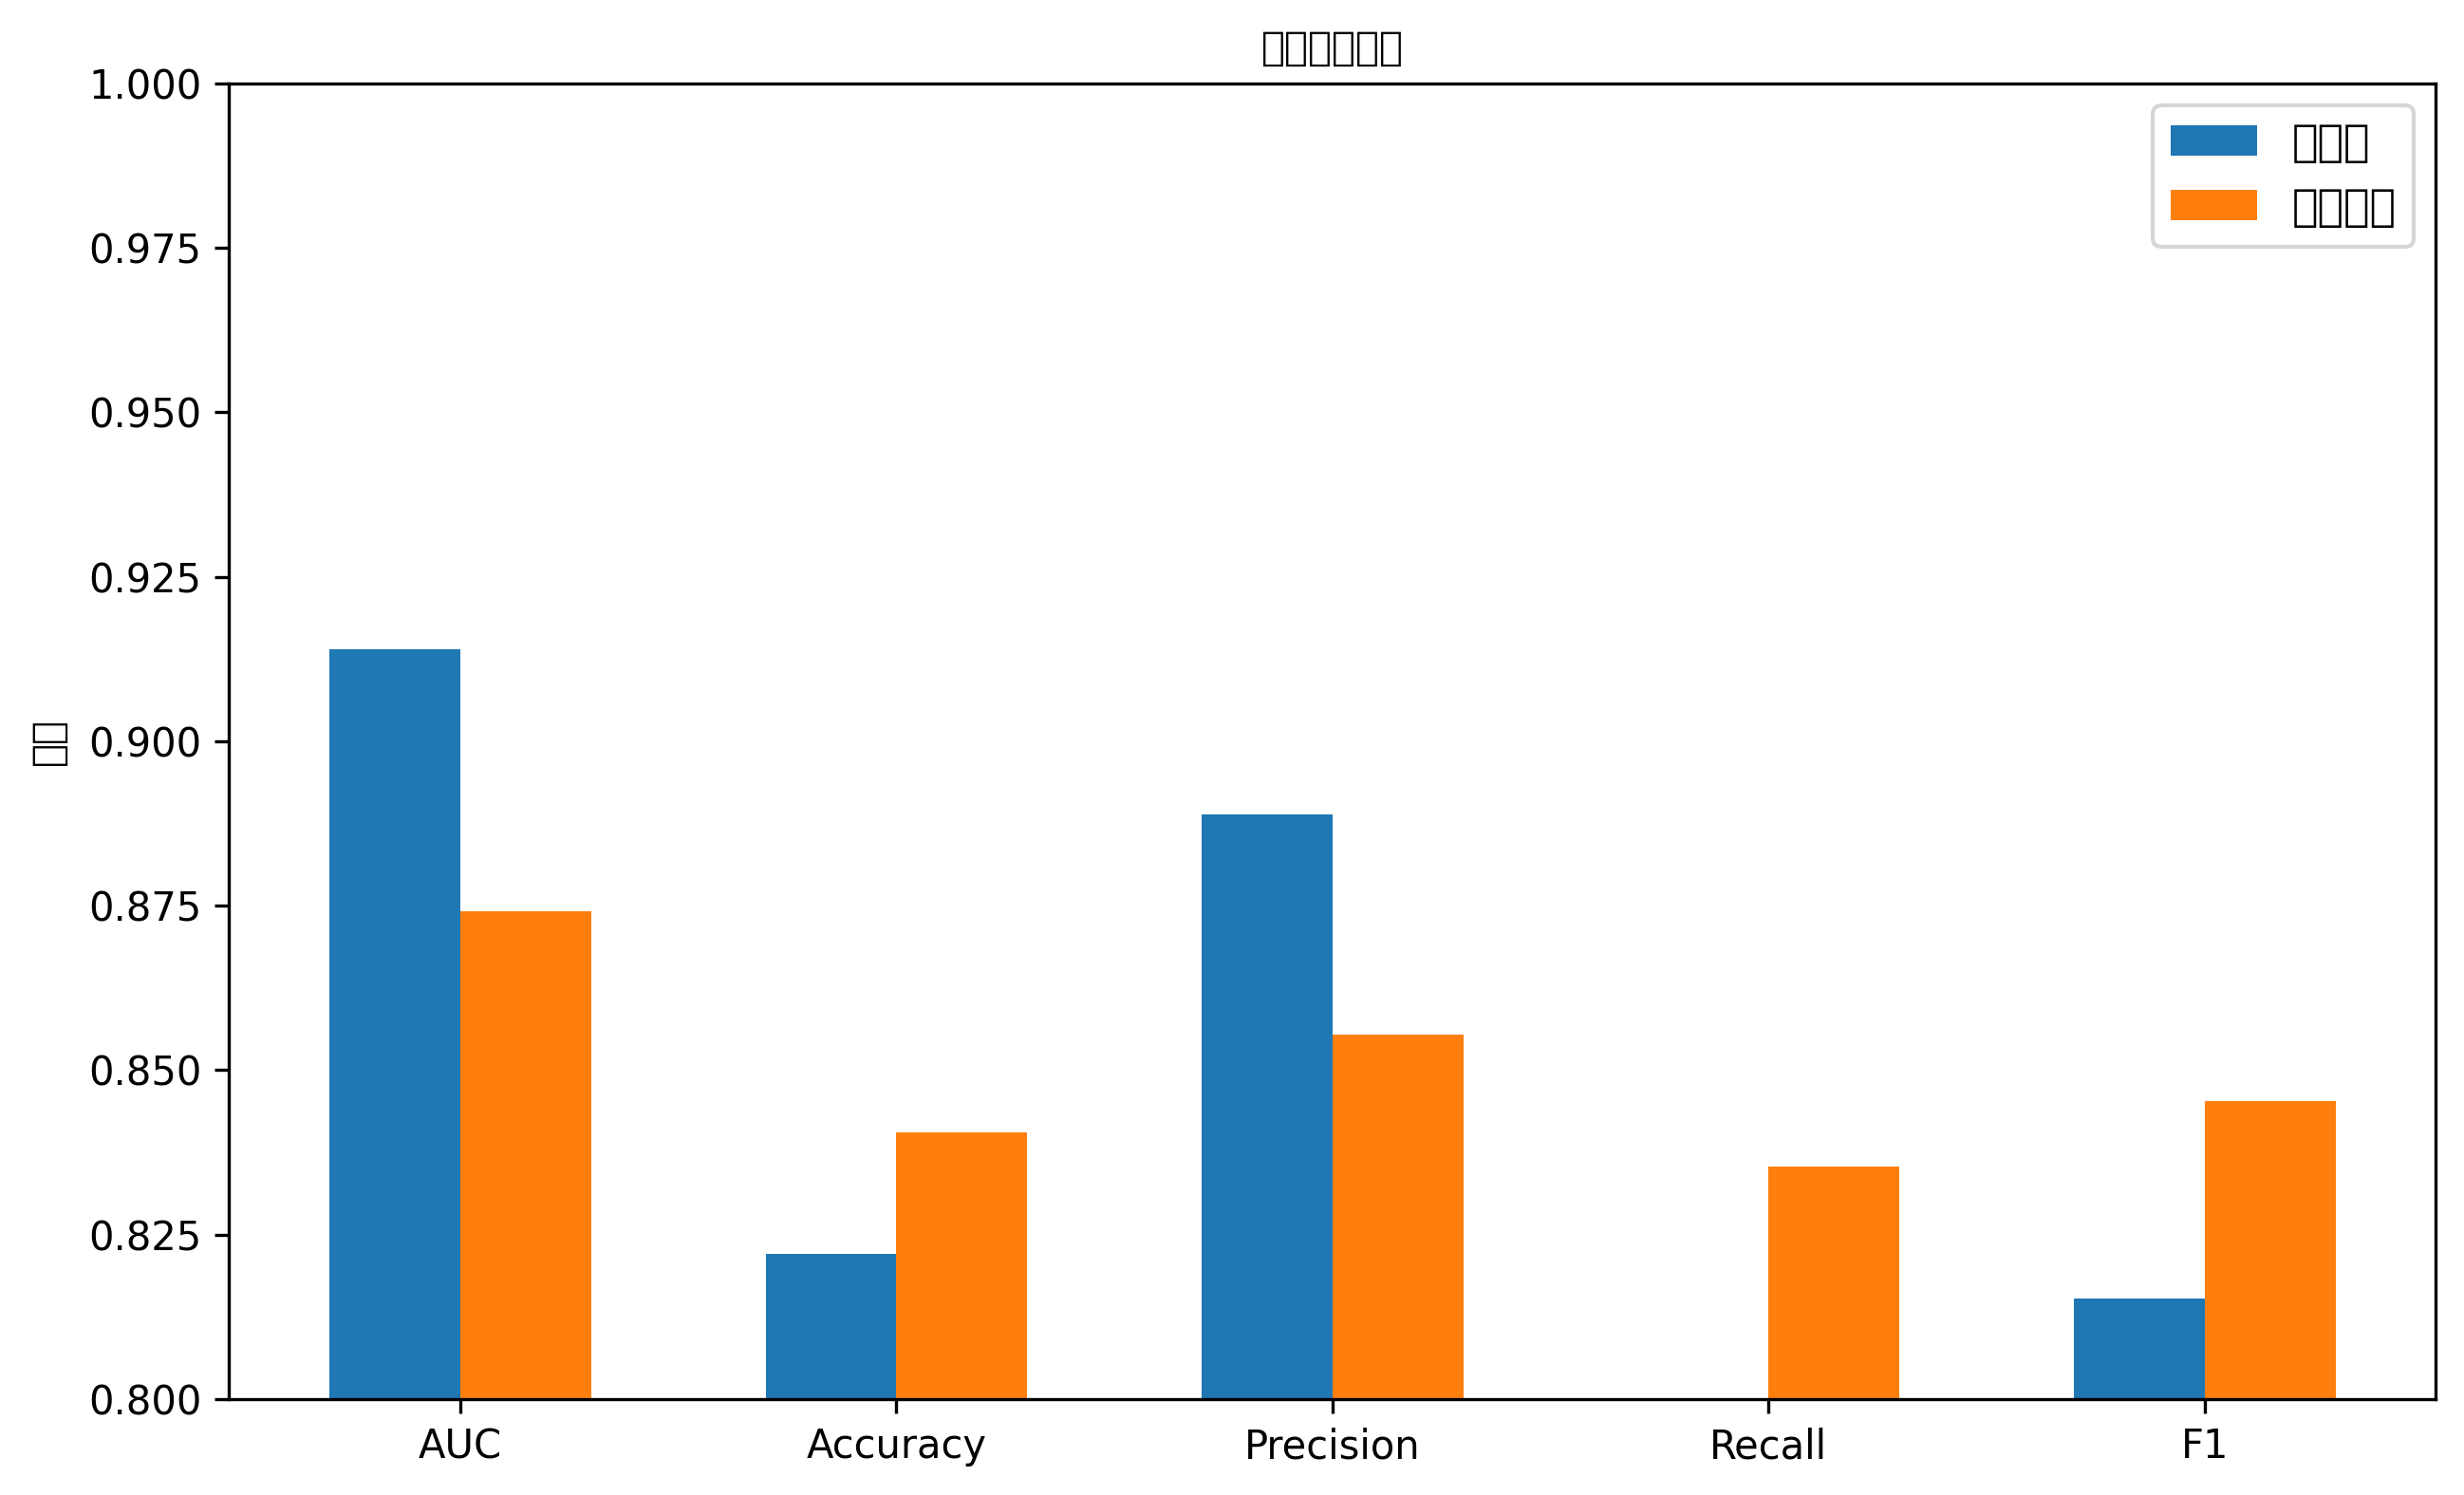

In [ ]:

def calculate_auc_ci(y_true, y_proba, confidence=0.95):
    """Harmonized calculation of AUC and its confidence intervals"""
    n = len(y_true)
    auc = roc_auc_score(y_true, y_proba)
    slices = [roc_auc_score(y_true[:i], y_proba[:i])
             for i in range(100, n, 100)]
    std_err = sem(slices)
    h = std_err * t.ppf((1 + confidence)/2, n-1)
    return auc, (max(0, auc-h), min(1, auc+h))

def evaluate_model(model, X, y, features):
    """Harmonization of evaluation functions"""
    assert set(features).issubset(X.columns), f"Missing features: {set(features)-set(X.columns)}"

    y_pred = model.predict(X[features])
    y_proba = model.predict_proba(X[features])[:, 1]

    auc, auc_ci = calculate_auc_ci(y, y_proba)

    return {
        'AUC': auc,
        'AUC_CI': auc_ci,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'Confusion_Matrix': confusion_matrix(y, y_pred)
    }

# === Data preparation ===
# Assume that the following variables already exist:
# - final_features: list of filtered features
# - x_train, y_train: complete training set
# - x_test, y_test: test set
# - best_model: original full model
# - final_metrics: initial evaluation results DataFrame

# Initialize streamlined models
pruned_model = clone(best_model.__class__(**best_model.get_params()))

# === New judgment logic ===
from sklearn.ensemble import HistGradientBoostingClassifier

# === Retraining (modified) ===
if isinstance(best_model, HistGradientBoostingClassifier):
    # Tuning parameters for HistGradientBoosting for scikit-learn
    pruned_model.set_params(
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        scoring='roc_auc'
    )
    pruned_model.fit(X_train[final_features], y_train)
else:

    pruned_model.fit(
        X_train[final_features],
        y_train,
        eval_set=[(X_test[final_features], y_test)] if hasattr(pruned_model, 'eval_set') else None,
        verbose=False
    )

# === Getting raw model performance ===
original_entry = final_metrics.iloc[0]
original_result = {
    'AUC': float(original_entry['AUC (95% CI)'].split()[0]),
    'AUC_CI': tuple(map(float,
                      re.findall(r"\d+\.\d+",
                               original_entry['AUC (95% CI)'])[1:])),
    'Accuracy': original_entry['Accuracy'],
    'Precision': original_entry['Precision'],
    'Recall': original_entry['Recall'],
    'F1': original_entry['F1-Score']
}

# === Evaluation of the streamlined model ===
pruned_result = evaluate_model(
    pruned_model,
    X_test,
    y_test,
    features=final_features
)

# === Generate a comparison report ===
comparison_df = pd.DataFrame({
    'norm': ['AUC', 'accuracy', 'Precision', 'recall', 'F1'],
    'original model': [
        f"{original_result['AUC']:.3f} ({original_result['AUC_CI'][0]:.3f}-{original_result['AUC_CI'][1]:.3f})",
        f"{original_result['Accuracy']:.3f}",
        f"{original_result['Precision']:.3f}",
        f"{original_result['Recall']:.3f}",
        f"{original_result['F1']:.3f}"
    ],
    'Compact model': [
        f"{pruned_result['AUC']:.3f} ({pruned_result['AUC_CI'][0]:.3f}-{pruned_result['AUC_CI'][1]:.3f})",
        f"{pruned_result['Accuracy']:.3f}",
        f"{pruned_result['Precision']:.3f}",
        f"{pruned_result['Recall']:.3f}",
        f"{pruned_result['F1']:.3f}"
    ]
})

print("\n=== Performance Comparison Report ===")
print(comparison_df.to_markdown(index=False, tablefmt="grid"))

# === Visualization Comparison ===
plt.figure(figsize=(10,6))
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))

# data conversion
original_values = [
    original_result['AUC'],
    original_result['Accuracy'],
    original_result['Precision'],
    original_result['Recall'],
    original_result['F1']
]
pruned_values = [
    pruned_result['AUC'],
    pruned_result['Accuracy'],
    pruned_result['Precision'],
    pruned_result['Recall'],
    pruned_result['F1']
]

plt.bar(x - 0.15, original_values, width=0.3, label='original model')
plt.bar(x + 0.15, pruned_values, width=0.3, label='Compact model')
plt.xticks(x, metrics)
plt.ylabel('numerical value')
plt.ylim(0.8, 1.0)
plt.title('Model Performance Comparison')
plt.legend()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

# === Model saving ===
model_package = {
    'model': pruned_model,
    'features': final_features,
    'performance': {
        'original': original_result,
        'pruned': pruned_result
    },
    'metadata': {
        'samples': {
            'train': len(y_train),
            'test': len(y_test)
        },
        'feature_counts': {
            'original': X_train.shape[1],
            'pruned': len(final_features)
        }
    }
}

joblib.dump(
    model_package,
    '/content/drive/MyDrive/code/IBD/2stage/stage2/CD_vs_UC_pruned_model.pkl'
)


Performing SHAP analysis for model interpretability...

Generating custom-colored SHAP bar plot...

Generating SHAP beeswarm plot with consistent colors...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


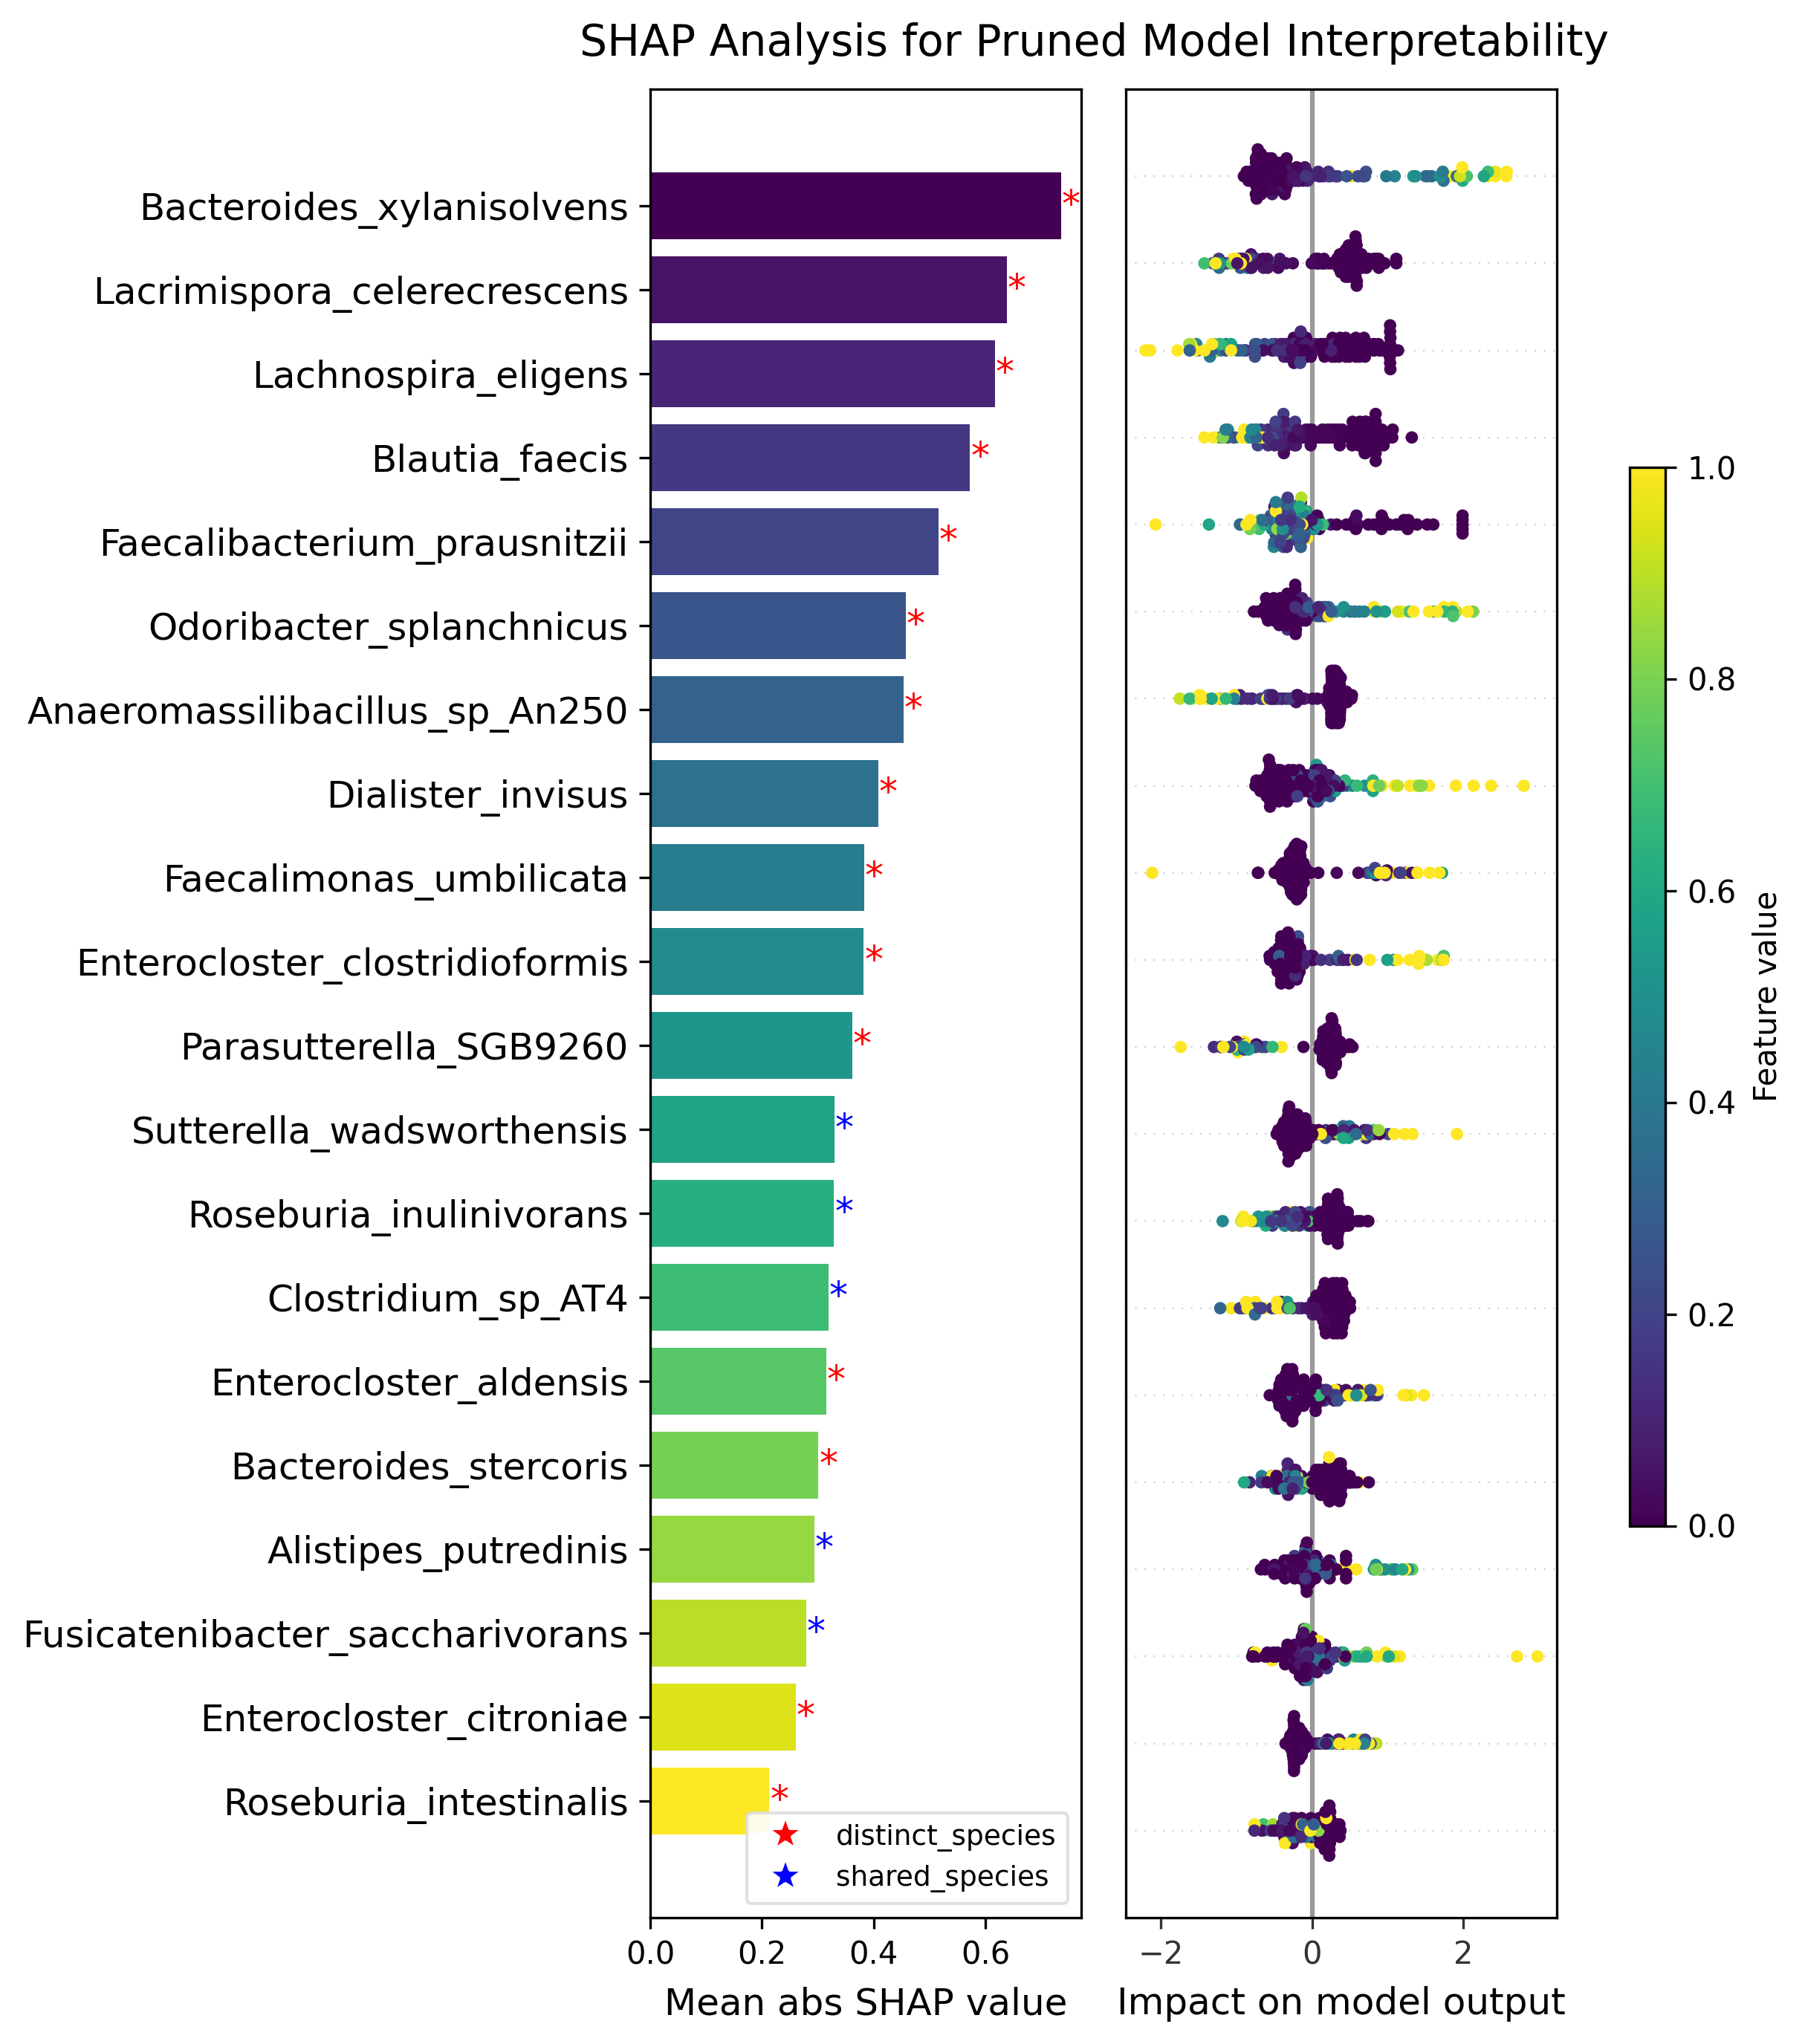

In [ ]:
# Set font for all plots
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Global font size for readability
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Axis label font size
plt.rcParams['xtick.labelsize'] = 10  # X-tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y-tick label size

# SHAP Analysis for model interpretability
print("\nPerforming SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(pruned_model)

# Generate SHAP values using explainer on X_test[final_features]
shap_values_explanation = explainer(X_test[final_features])
shap_values = shap_values_explanation

# Create figure and set size to align both plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)  # Slightly increase space between the two plots

# 1. Custom-colored SHAP bar plot
print("\nGenerating custom-colored SHAP bar plot...")
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test[final_features].columns

# Store feature importance in DataFrame and sort by importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

# Custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))

# Plot custom bar plot
axes[0].barh(importance_df['feature'], importance_df['importance'], color=colors)

legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=12, label='distinct_species'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=12, label='shared_species')
]

axes[0].legend(handles=legend_elements,
              loc='lower right',
              frameon=True,
              framealpha=0.9,
              edgecolor='#DDDDDD',
              title='',
              title_fontsize=10,
              fontsize=9)

axes[0].invert_yaxis()

# Add strain labeling
for i, feature in enumerate(importance_df['feature']):
    if feature in distinct_species_list:
      # Add a red star for distinct species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='red', fontsize=12, va='center')
    elif feature in shared_species_list:
      # Add a blue star for shared species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='blue', fontsize=12, va='center')

# Hide x-axis label and title by setting them as empty strings
axes[0].set_xlabel("Mean abs SHAP value", fontsize=12)  # Hide x-axis label for the bar plot
axes[0].set_title("")   # Hide title for the bar plot
axes[0].tick_params(axis='y', labelsize=12)  # Increase font size for feature names

# Set consistent x-axis tick parameters for the bar plot
axes[0].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# 2. SHAP beeswarm plot with consistent colors
print("\nGenerating SHAP beeswarm plot with consistent colors...")
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test[final_features], plot_type="dot", max_display=20, show=False, color_bar=False, cmap="viridis")
axes[1].tick_params(labelleft=False)
axes[1].tick_params(left=False)
axes[1].set_title("")   # Hide title for beeswarm plot
axes[1].set_xlabel("Impact on model output", fontsize=12)  # Hide x-axis label for beeswarm plot
axes[1].spines[['left', 'right', 'top']].set_visible(True)

# Set consistent x-axis tick parameters for the beeswarm plot
axes[1].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# Add a color bar next to the beeswarm plot with adjusted size
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted color bar position and size
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label="Feature value", orientation='vertical')

# Adjust layout and save image with high resolution
fig.suptitle('SHAP Analysis for Pruned Model Interpretability',
            x=0.62,
            y=0.96,
            fontsize=14,
            fontweight='normal')

plt.tight_layout(rect=[0, 0, 0.9, 0.98])  # Reserve top 5% space
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage2/SHAP_pruned_model.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

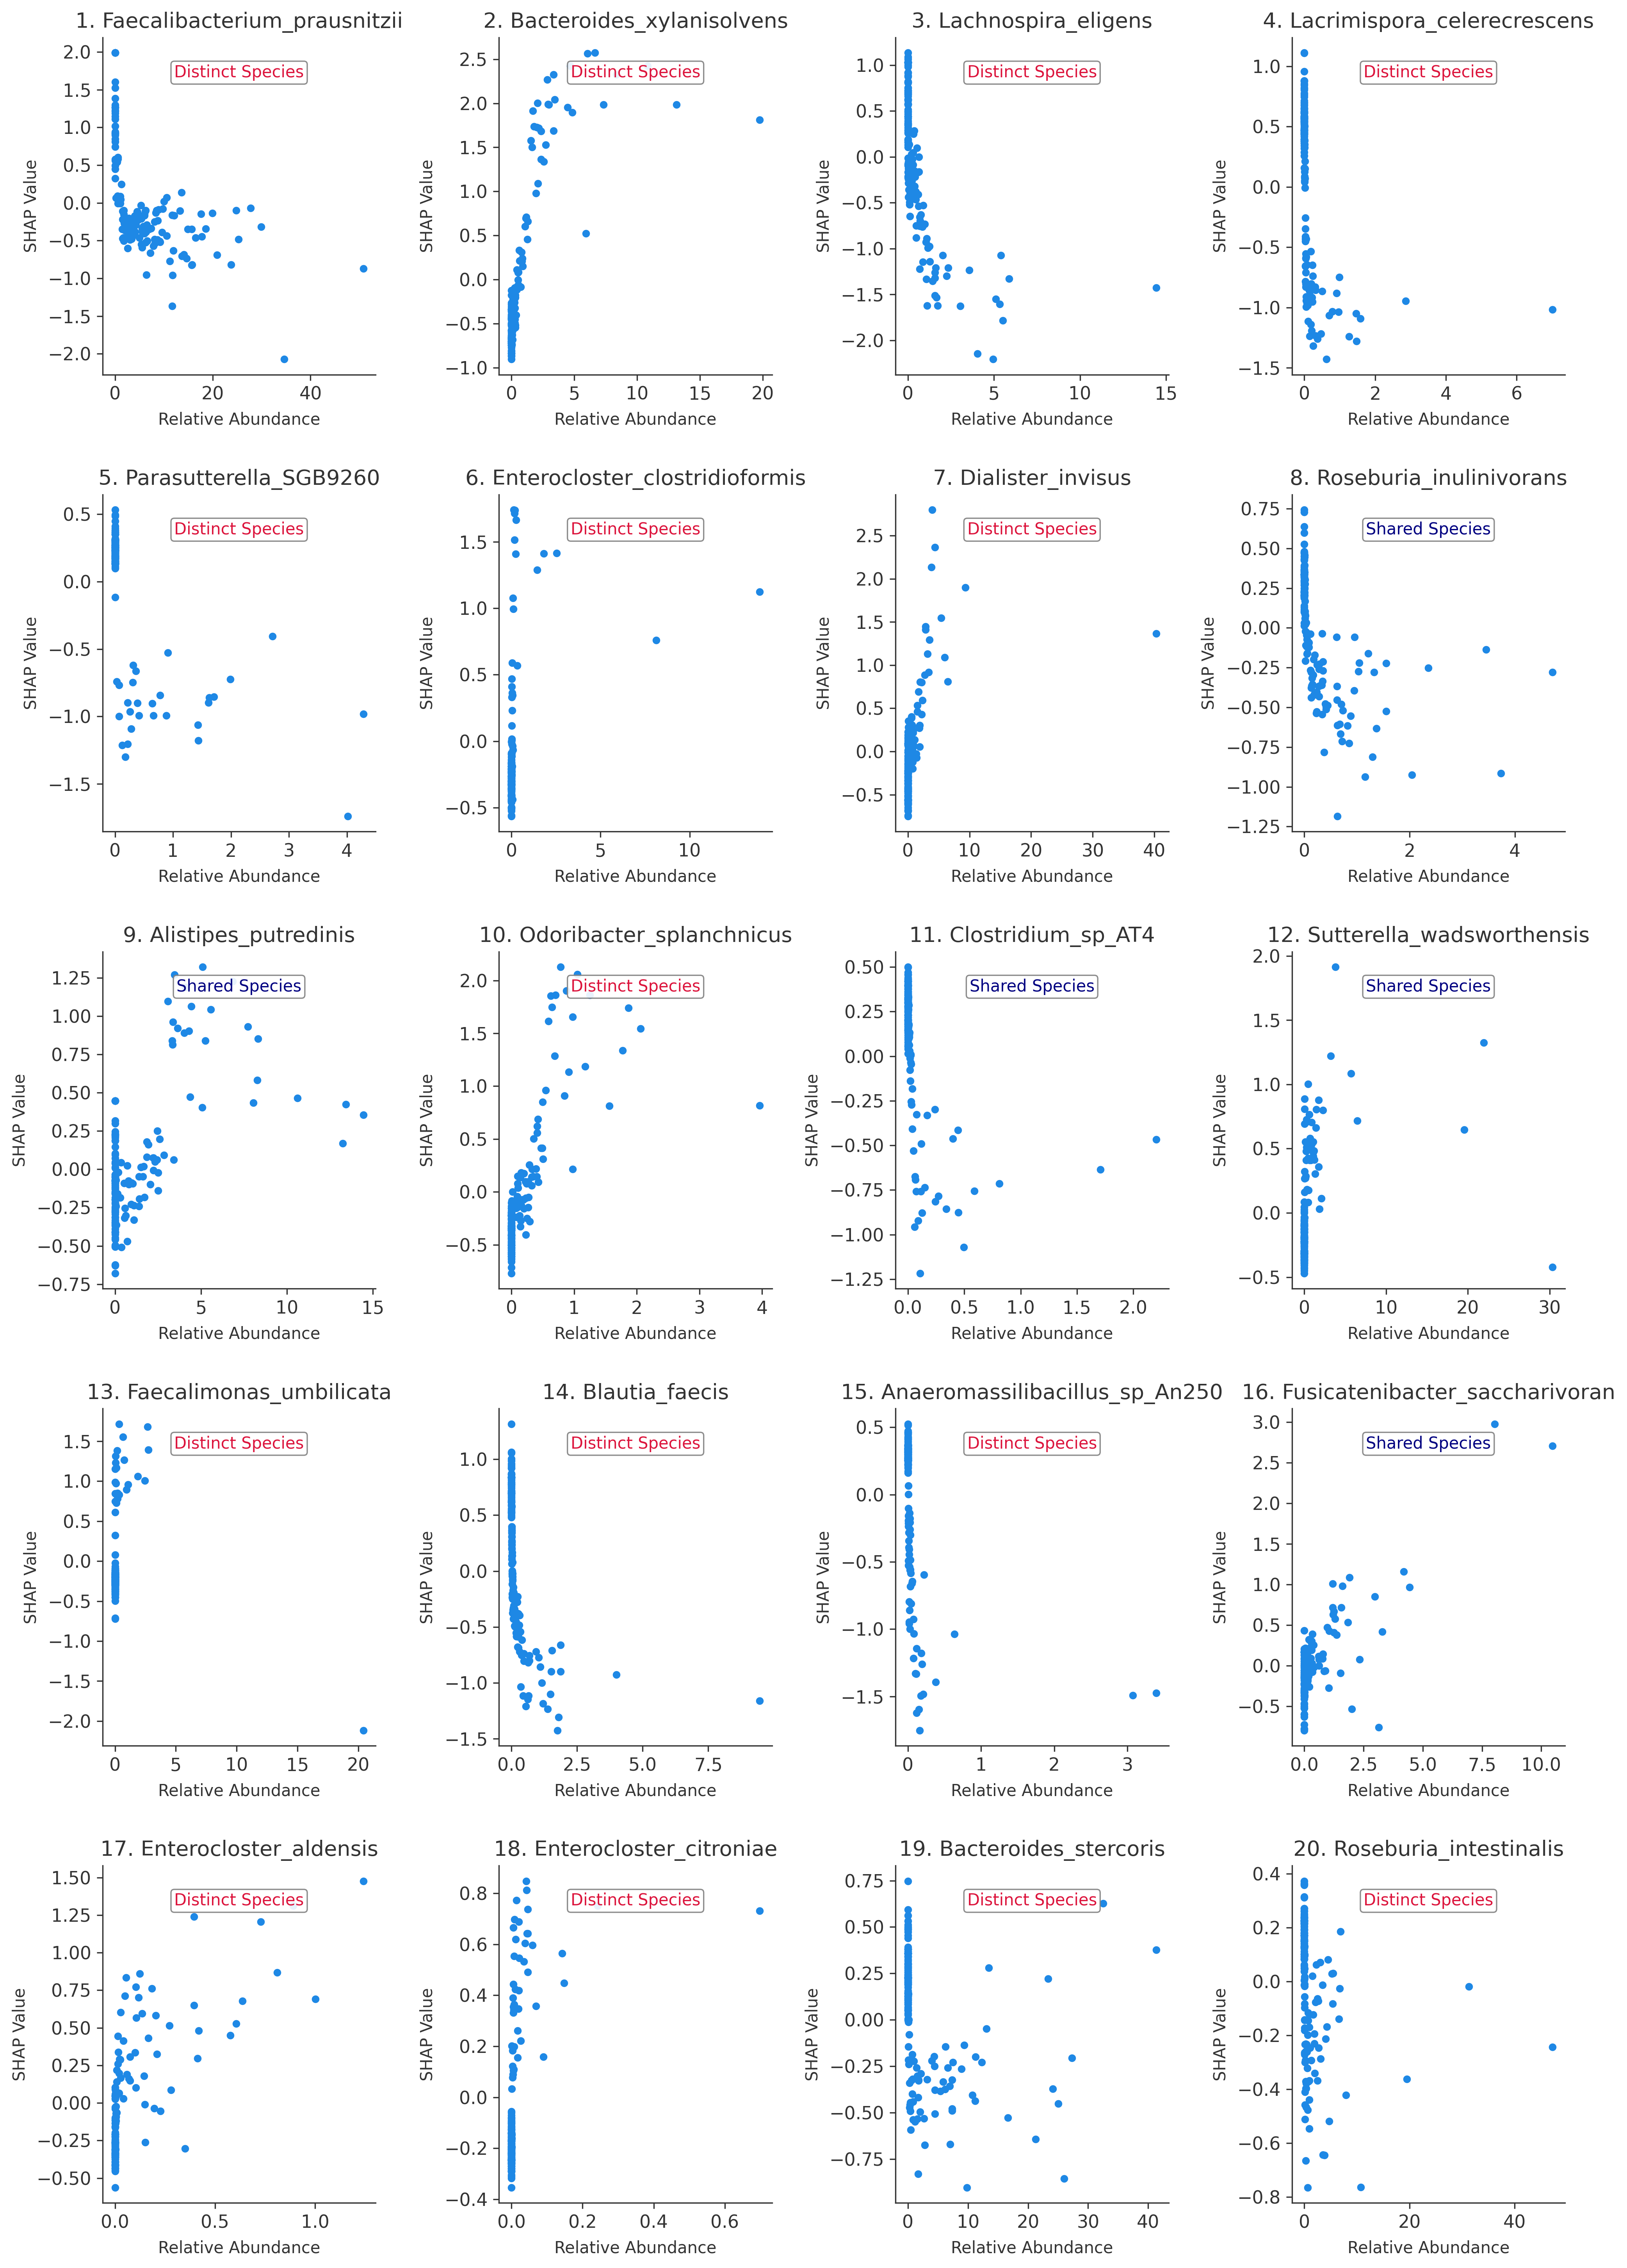

In [ ]:
plt.figure(figsize=(14, 20))


pruned_features = final_features
pruned_shap = explainer.shap_values(X_test[pruned_features])

for i, feature in enumerate(pruned_features, 1):
    ax = plt.subplot(5, 4, i)


    feature_idx = pruned_features.index(feature)


    shap.dependence_plot(
        feature_idx,
        pruned_shap,
        X_test[pruned_features].values,
        interaction_index=None,
        ax=ax,
        title=f"{i}. {feature[:30]}".rstrip('_'),
        cmap=cmap,
        dot_size=22,
        show=False
    )


    ax.set_xlabel("Relative Abundance", fontsize=10)
    ax.set_ylabel("SHAP Value", fontsize=10)


    label_y_position = 0.92
    bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="grey", lw=0.8, alpha=0.9)

    if feature in distinct_species_list:
        ax.text(0.5, label_y_position, 'Distinct Species',
               color='crimson', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)
    elif feature in shared_species_list:
        ax.text(0.5, label_y_position, 'Shared Species',
               color='navy', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)


plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=2.0)
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage2/SHAP_dependence_pruned_model.png", dpi=300, bbox_inches='tight')
plt.show()